In [24]:
import torch
import torch.optim
import torch.utils.data
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
import copy


# Import CIFAR-10 dataset

In [4]:
def load_dataset(batch_size):
    mean = [x/255 for x in [125.30691805, 122.95039414, 113.86538318]]
    std = [x/255 for x in [62.99321928, 62.08870764, 66.70489964]]
    
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),
         transforms.Normalize(mean, std)])
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean, std)])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Mask class for pruning

In [5]:
class Mask:
    """
    Used to determine the least imporant filters and to prune them
    """
    
    def __init__(self, model, rate):
        self.model = model
        self.rate = rate
        self.model_size = {}
        self.model_length = {}
        self.masks = {}
        
    
    def init_length(self):
        """
        Initialize size of parameters for each layer
        model_size: shape of weights
        model_length: number of parameters
        """
        for index, item in enumerate(self.model.parameters()):
            self.model_size[index] = item.size()
            self.model_length[index] = np.prod(list(item.size()))

    
    def get_mask(self, weights, length):
        """
        Get mask for one conv layer
        """
        mask = np.ones(length)
        if len(weights.size())==4: # check if it is conv layer
            num_prune = int(weights.size()[0]*self.rate)
            kernel_params = weights.view(weights.size()[0],-1)
            kernel_length = kernel_params.size()[1]
            
            norm = torch.norm(kernel_params, 2, 1).cpu().numpy()
            sorted_index = norm.argsort()[:num_prune]
                       
            for i in range(len(sorted_index)):
                index = sorted_index[i]
                # set elements corresponding to all weights in that kernel to zero
                mask[index*kernel_length:(index+1)*kernel_length] = 0    
        
        return mask
            

    def init_mask(self):
        """
        Get masks for each conv layer
        """
        for index, item in enumerate(self.model.parameters()):
            self.masks[index] = self.get_mask(item.data, self.model_length[index])
            self.masks[index] = torch.FloatTensor(self.masks[index])
            
    def do_mask(self):
        """
        Set weights of pruned kernels to zero by multiplying weights with the mask
        """
        for index, item in enumerate(self.model.parameters()):
            weights = item.data.view(self.model_length[index])
            masked_weights = self.masks[index] * weights
            item.data = masked_weights.view(self.model_size[index])
            

    def count_zero(self): # should we change this to sum across all layers?
        """
        Prints number of zero and non-zero weights in each layer
        """
        for index, item in enumerate(self.model.parameters()):
            if len(item.data.size())==4: # check if is conv layer
                weights = item.data.view(self.model_length[index])
                weights = weights.cpu().numpy()
                non_zero = np.count_nonzero(weights)
                zero = len(weights) - non_zero

                print("Layer: {} - No. of zero weights = {} - No. of non-zero weights = {}".format(
                    index, zero, non_zero))

            

# Model

In [6]:
def metrics(model, device, criterion, data_loader):
    """
    Returns loss and accuracy
    """
    model.eval()
    loss = 0
    correct = 0
    
    start_time = time.time()
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data = torch.autograd.Variable(data)
            target = torch.autograd.Variable(target)
            
            output = model(data)
            loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    loss /= len(data_loader)
    acc = 100. * correct / len(data_loader.dataset)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return loss, acc, time_taken

def plot_curves(curves, title, parameter, labels):
    for i in range(len(curves)):
        curve = curves[i]
        label = parameter + ': ' + str(labels[i])
        plt.plot(curve,label=label)
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
def train(model, device, criterion, train_loader, test_loader, optimizer, epoch):
    """
    Forward and backward pass
    """
    model.train()
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = torch.autograd.Variable(data)
        target = torch.autograd.Variable(target)
        
        output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    time_taken = end_time - start_time
    train_loss, train_acc, _ = metrics(model, device, criterion, train_loader)
    print("Train Epoch: {} - Time taken: {:.1f}s\nTrain Loss: {:.4f} - Train Accuracy: {:.1f}%".format(epoch, time_taken, train_loss, train_acc))
    
    return train_loss, train_acc

In [28]:
def run(arch='resnet18', pruning_rate=0.1, epochs=10, pruning_epoch=1, batch_size=128, learning_rate=0.1, momentum=0.9, decay=0.0005, pruning_scale=1.0, pr_threshold=1.0):
    """
    Do training and pruning
    """
    start_pr = pruning_rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True 

    train_loader, test_loader = load_dataset(batch_size)
    num_classes = 10 # cifar-10
    model = models.__dict__[arch](num_classes)
    
    model = model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=decay, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss()
    
    _, test_acc, _ = metrics(model, device, criterion, test_loader)
    print("Test Accuracy before pruning: {:.1f}%".format(test_acc))
    
    m = Mask(model.cpu(), pruning_rate)
    m.init_length()
    
    # prune the filters
    m.init_mask()
    m.do_mask()
    model = m.model
    model.to(device)
    
    _, test_acc, _ = metrics(model, device, criterion, test_loader)
    print("Test Accuracy after pruning: {:.1f}%".format(test_acc))
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    # final model
    final_model = model
    best_test_accuracy = -1.0
    best_epoch = 0
    best_pruning_rate = 0
    
    # Main training loop
    for epoch in range(1, epochs+1):

        # train for one epoch
        train_loss, curr_train_acc = train(model, device, criterion, train_loader, test_loader, optimizer, epoch)
        
        if epoch % pruning_epoch == 0 or epoch == epochs:
            # pruning and comparing
            test_loss, test_acc, _ = metrics(model, device, criterion, test_loader)
            print("Test Accuracy before pruning: {:.1f}%".format(test_acc))

            # adaptive pruning (if accuracy increases, upscale the pruning rate)
            if test_acc > best_test_accuracy:
                pruning_rate = pruning_rate * pruning_scale
                best_test_accuracy = test_acc
                best_epoch = epoch-1
                best_pruning_rate = pruning_rate
                final_model = copy.deepcopy(model) 

            if pruning_rate >= pr_threshold:
                pruning_rate = pr_threshold
                pruning_scale = 1.0
            m.rate = pruning_rate
            print(m.rate)
            m.model = model.cpu()
            m.init_mask()
            m.do_mask()
            model = m.model
            model.to(device)

            test_loss, test_acc, _ = metrics(model, device, criterion, test_loader)
            print("Test Accuracy after pruning: {:.1f}%".format(test_acc))
            # store the best model so far

        train_losses.append(train_loss.item())
        train_accs.append(curr_train_acc)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
    
    test_loss, test_acc, time_taken = metrics(final_model, device, criterion, test_loader)
    print("\nTraining finished.\nTest accuracy: {:.1f}% - Inference time: {:.4f}s".format(test_acc, time_taken))
    print(f"Best performing epoch: {best_epoch}, best performing pruning rate: {best_pruning_rate}")

    with open(arch+'_pr'+str(start_pr)+'_pe'+str(pruning_epoch)+'_ps'+str(pruning_scale)+'_pt'+str(pr_threshold)+'.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(train_losses)
        wr.writerow(test_losses)
        wr.writerow(train_accs)
        wr.writerow(test_accs)
        
    return model, train_losses, train_accs, test_losses, test_accs


In [29]:
train_loss_curves = []
train_acc_curves = []
test_loss_curves = []
test_acc_curves = []

In [30]:
model, train_losses, train_accs, test_losses, test_accs = run(arch='resnet18', pruning_rate=0.3, epochs=5, pruning_epoch=1, pruning_scale=1.2 ,pr_threshold=0.5)
train_loss_curves.append(train_losses) 
train_acc_curves.append(train_accs)
test_loss_curves.append(test_losses)
test_acc_curves.append(test_accs)


Files already downloaded and verified
Files already downloaded and verified
Test Accuracy before pruning: 0.0%
Test Accuracy after pruning: 0.0%
Train Epoch: 1 - Time taken: 16.2s
Train Loss: 2.1213 - Train Accuracy: 24.7%
Test Accuracy before pruning: 27.1%
0.36
Test Accuracy after pruning: 19.4%
Train Epoch: 2 - Time taken: 16.2s
Train Loss: 1.7394 - Train Accuracy: 35.6%
Test Accuracy before pruning: 39.1%
0.432
Test Accuracy after pruning: 22.5%
Train Epoch: 3 - Time taken: 16.2s
Train Loss: 1.6068 - Train Accuracy: 42.3%
Test Accuracy before pruning: 43.7%
0.5
Test Accuracy after pruning: 12.4%
Train Epoch: 4 - Time taken: 16.2s
Train Loss: 1.4982 - Train Accuracy: 46.2%
Test Accuracy before pruning: 48.4%
0.5
Test Accuracy after pruning: 36.7%
Train Epoch: 5 - Time taken: 16.2s
Train Loss: 1.4279 - Train Accuracy: 48.5%
Test Accuracy before pruning: 49.5%
0.5
Test Accuracy after pruning: 32.9%

Training finished.
Test accuracy: 49.5% - Inference time: 1.9278s
Best performing epoc

In [32]:
model, train_losses, train_accs, test_losses, test_accs = run(arch='resnet18', pruning_rate=0.1, epochs=5, pruning_epoch=1)
train_loss_curves.append(train_losses)
train_acc_curves.append(train_accs)
test_loss_curves.append(test_losses)
test_acc_curves.append(test_accs)


Files already downloaded and verified
Files already downloaded and verified
Test Accuracy before pruning: 0.0%
Test Accuracy after pruning: 0.0%
Train Epoch: 1 - Time taken: 114.3s
Train Loss: 1.9015 - Train Accuracy: 29.4%
Test Accuracy before pruning: 28.9%
Test Accuracy after pruning: 28.1%
Train Epoch: 2 - Time taken: 110.2s
Train Loss: 1.6312 - Train Accuracy: 38.8%
Test Accuracy before pruning: 40.8%
Test Accuracy after pruning: 40.5%
Train Epoch: 3 - Time taken: 113.9s
Train Loss: 1.4431 - Train Accuracy: 47.4%
Test Accuracy before pruning: 48.9%
Test Accuracy after pruning: 49.0%
Train Epoch: 4 - Time taken: 116.9s
Train Loss: 1.4776 - Train Accuracy: 51.1%
Test Accuracy before pruning: 52.0%
Test Accuracy after pruning: 51.9%
Train Epoch: 5 - Time taken: 119.4s
Train Loss: 1.1887 - Train Accuracy: 57.4%
Test Accuracy before pruning: 60.1%
Test Accuracy after pruning: 59.9%

Training finished.
Test accuracy: 59.9% - Inference time: 9.6780s


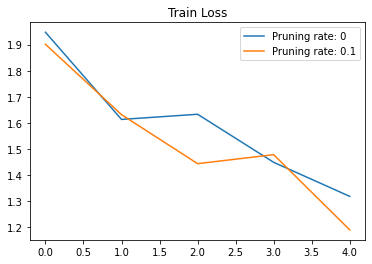

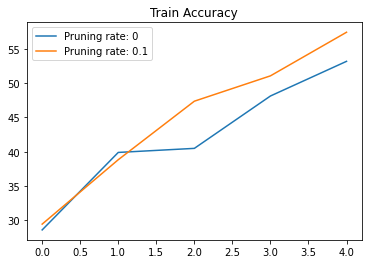

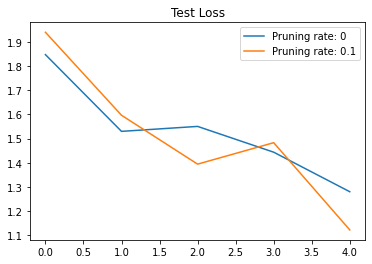

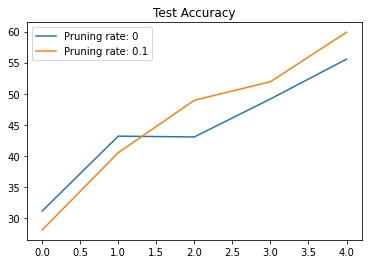

In [33]:
plot_curves(train_loss_curves, "Train Loss", "Pruning rate", [0,0.1])
plot_curves(train_acc_curves, "Train Accuracy", "Pruning rate", [0,0.1])
plot_curves(test_loss_curves, "Test Loss", "Pruning rate", [0,0.1])
plot_curves(test_acc_curves, "Test Accuracy", "Pruning rate", [0,0.1])

In [5]:
print(models.__dict__['alexnet'])

<function alexnet at 0x00000274283F03A8>
